# Visualizing the Performance of the Actor Critic Agent

In [1]:
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES']="-1"

import gym
import sys
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import clear_output
from collections import defaultdict

import cube_gym
from actor_critic import ActorCritic
from common.multiprocessing_env import SubprocVecEnv

In [2]:
SCRAMBLE = int(input('Enter the Scramble Size: '))
STOCHASTIC = input('Stocchastic? (y/n): ') == 'y'
SHOW_STATES = input('Show States? (y/n): ') == 'y'
print('Scramble: ', SCRAMBLE)
print('Stochastic: ', STOCHASTIC)
print('Show States: ', SHOW_STATES)

Scramble:  5
Stochastic:  True
Show States:  True


Now we select which model we are going to use

In [3]:
# Find all the experiments
experiments = defaultdict(lambda: [])

for r, d, f in os.walk('./experiments/'):
    for file in f:
        if ".ckpt.index" in file:
            iternum = file.replace('.ckpt.index', '')
            if iternum == 'final':
                iternum = int(sys.maxsize)
            experiments[r].append(int(iternum))
            
exp = None
ckpt = None

print('Experiments')
print('===========')
for i, e in zip(range(len(experiments.keys())), sorted(experiments.keys())):
    print('[%i] %s' % (i+1, e))
    
exp = list(sorted(experiments.keys()))[int(input('Enter the experiment number you wish to load: ')) - 1]

print('\nCheckpoints')
print('===========')
for i, e in zip(range(len(experiments[exp])), sorted(experiments[exp])):
    print('[%i] %s' % (i+1, e))
    
ckpt = sorted(experiments[exp])[int(input('Choose which checkpoint to load: ')) - 1]
ckpt = str(ckpt) + '.ckpt'

hyperparams = exp.split('/')
policy_def = hyperparams[3]
env_id = hyperparams[5]
orient_scramble = True if hyperparams[7] == 'os_yes' else False

Experiments
[1] ./experiments/a2c/c2d+:64:3:1_c2d+:16:3:1_h:4096:2048_pi_vf/NULL/cube-x3-v0/adaptive/os_yes/iter_1000000.0/lr_0.0007/pgk_1.0/vfk_0.5/entk_0.05/2018-07-23-14-53-32-792206
[2] ./experiments/em/h:4096:4096:4096/cube-x3-v0/spectrum/os_yes/iter_100000.0/lr_0.0007/obk_1.0/rwk_1.0/2018-07-23-15-53-42-422677
[3] ./experiments/em/h:4096:4096:4096/cube-x3-v0/spectrum/os_yes/iter_100000.0/lr_0.0007/obk_1.0/rwk_1.0/2018-07-23-15-54-47-865683
[4] ./experiments/em/h:4096:4096:4096/cube-x3-v0/spectrum/os_yes/iter_100000.0/lr_0.001/obk_1.0/rwk_1.0/2018-07-23-14-47-33-786456
[5] ./experiments/em/h:4096:4096:4096/cube-x3-v0/spectrum/os_yes/iter_100000.0/lr_0.001/obk_1.0/rwk_1.0/2018-07-23-15-09-49-803102
[6] ./experiments/em/h:4096:4096:4096/cube-x3-v0/spectrum/os_yes/iter_100000.0/lr_0.001/obk_1.0/rwk_1000.0/2018-07-23-14-57-26-233548

Checkpoints
[1] 313000
[2] 314000
[3] 315000
[4] 316000
[5] 317000


##### The *env_fn* gives you the oppurtunity to configure the environment.

In [4]:
def env_fn():
    env = gym.make(env_id)
    env.unwrapped._refresh(SCRAMBLE,SCRAMBLE+2,adaptive=False, orient_scramble=orient_scramble)
    return env

# This is just so we have the action list available to us
actions = env_fn().unwrapped.action_list
print('\nList of Actions')
for a in actions:
    print(a, end=' ')


List of Actions
r l u d f b .r .l .u .d .f .b x y z .x .y .z 

In [5]:
nenvs = 7
envs = SubprocVecEnv([env_fn for _ in range(nenvs)])
envs.seed(int(time.time()))
print('Made ', nenvs, ' environments of ', env_id)

Made  7  environments of  cube-x3-v0


### Setup TensorFlow and the Actor-Critic Model

In [6]:
sess = tf.Session()

actor_critic = ActorCritic(sess, policy_def,
        envs.observation_space.shape, envs.action_space, 1, 5,
        1.0, 0.5, 0.01, 0.5, 7e-4, 0.99, 1e-5, False)

actor_critic.load(os.path.join(exp, ckpt))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

INFO:tensorflow:Restoring parameters from ./experiments/a2c/c2d+:64:3:1_c2d+:16:3:1_h:4096:2048_pi_vf/NULL/cube-x3-v0/adaptive/os_yes/iter_1000000.0/lr_0.0007/pgk_1.0/vfk_0.5/entk_0.05/2018-07-23-14-53-32-792206/317000.ckpt


### Now its time to do a test run on the environment

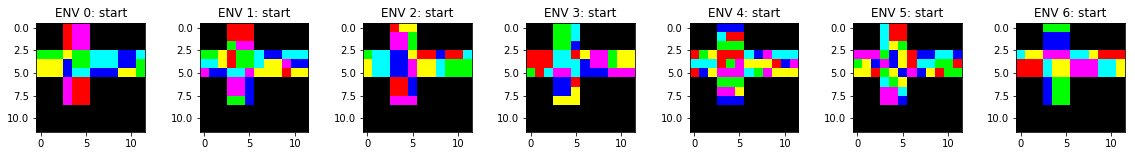

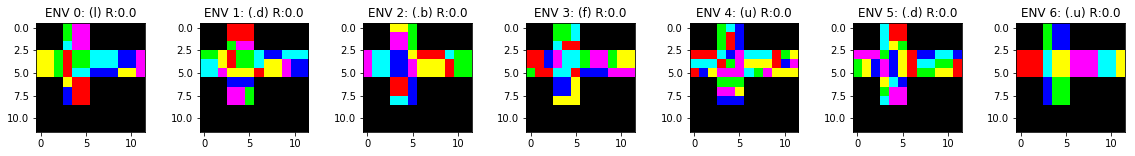

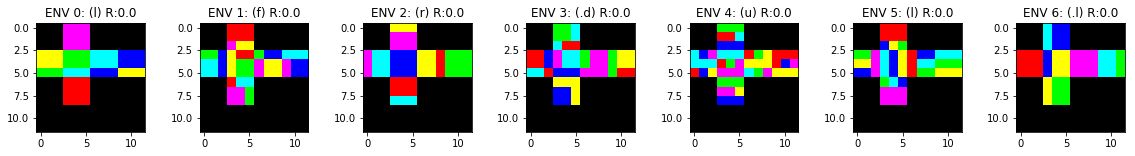

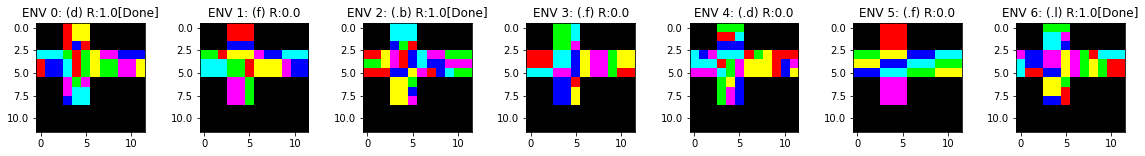

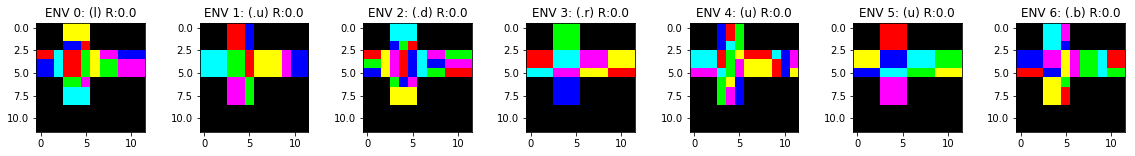

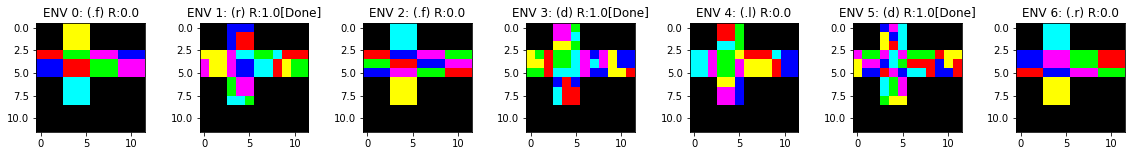

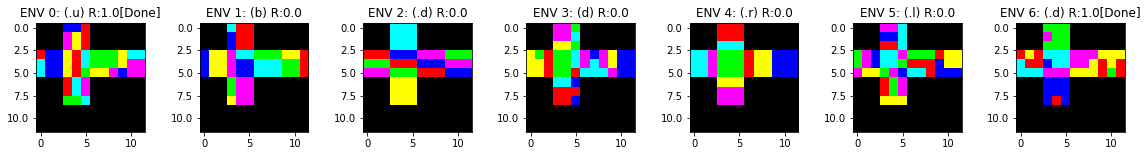

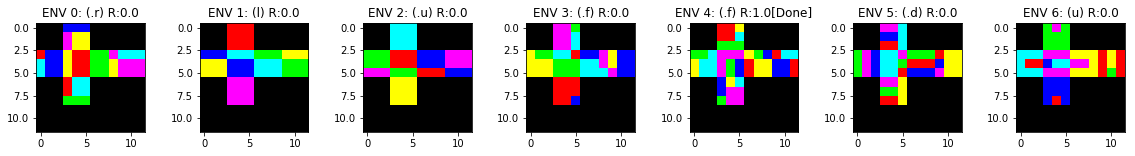

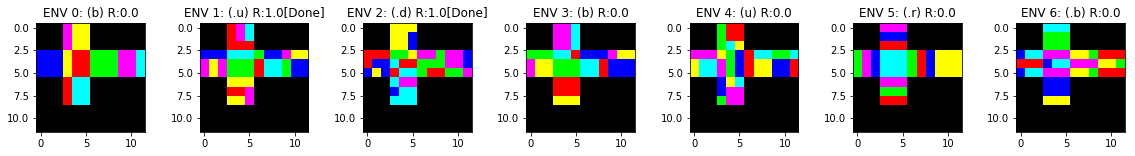

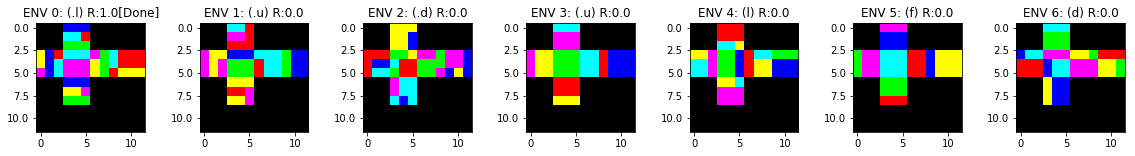

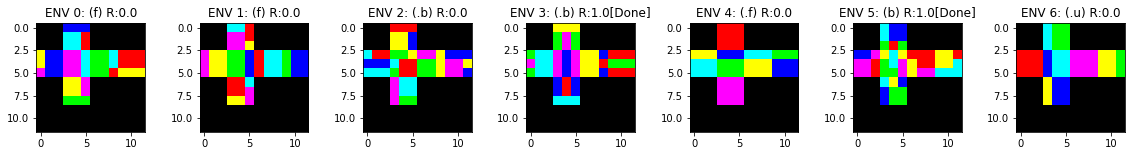

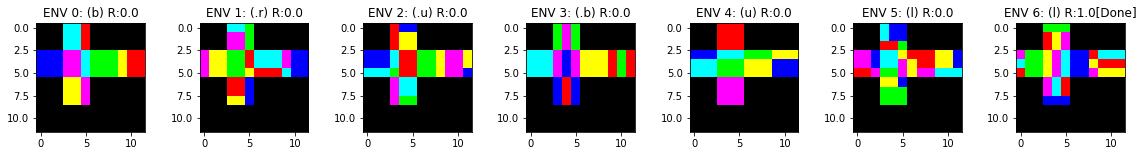

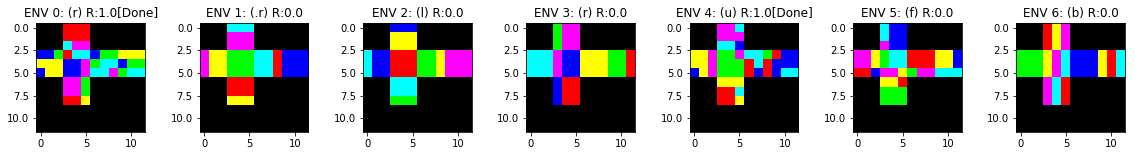

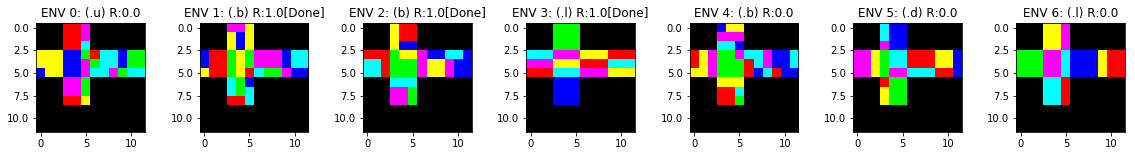

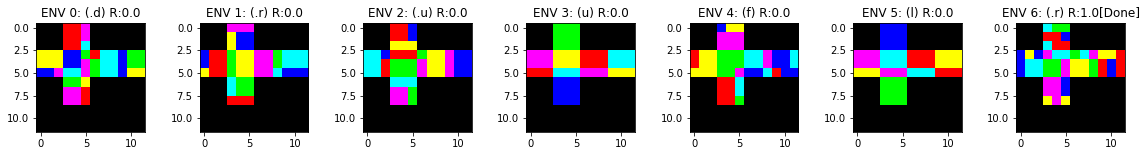

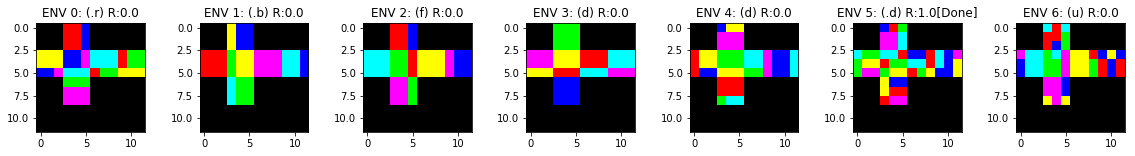

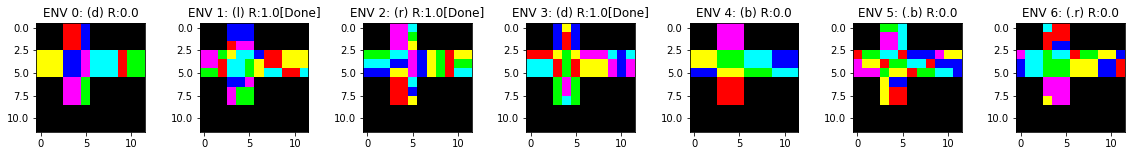

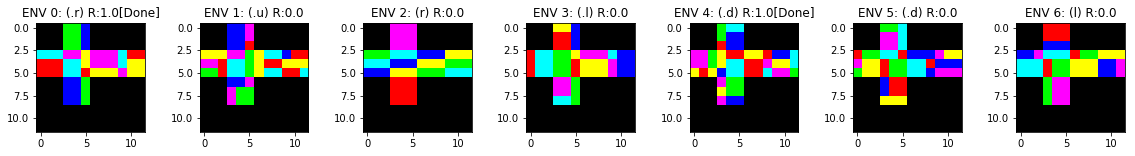

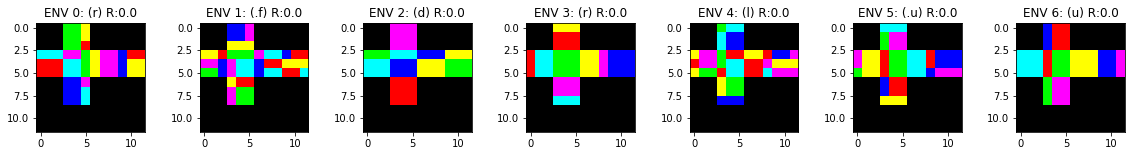

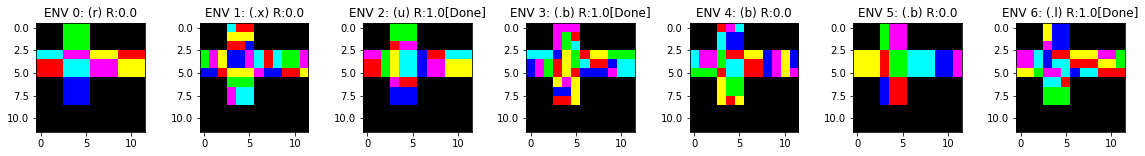

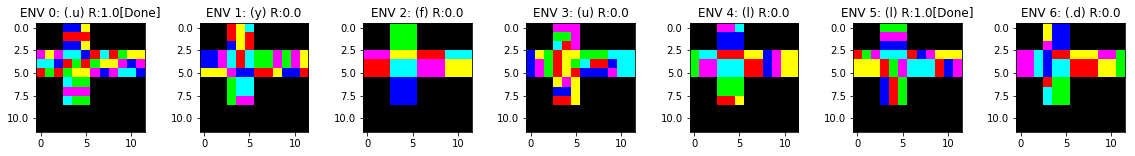

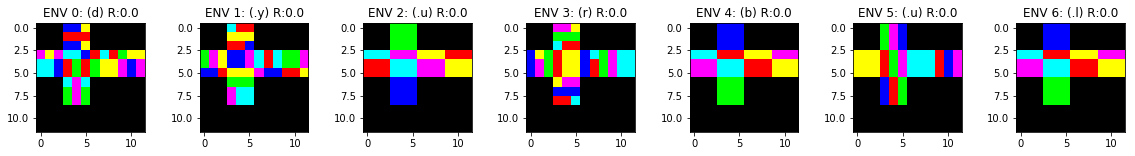

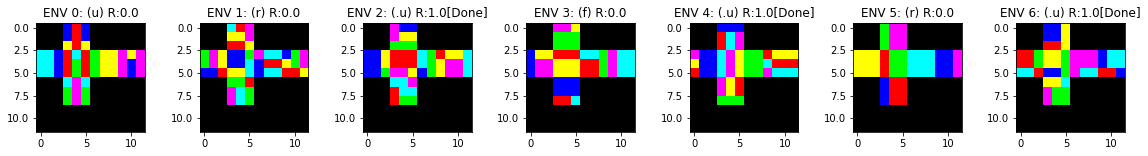

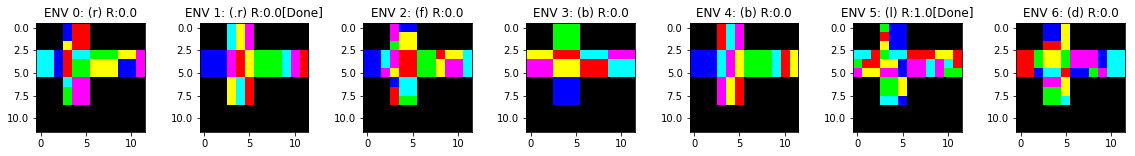

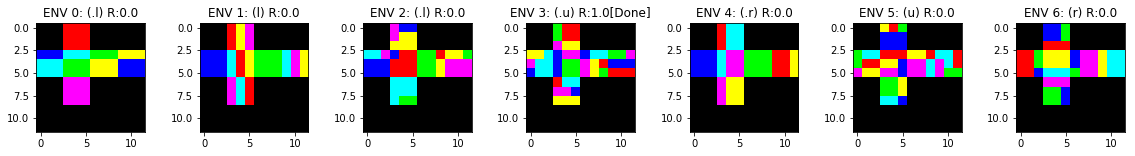

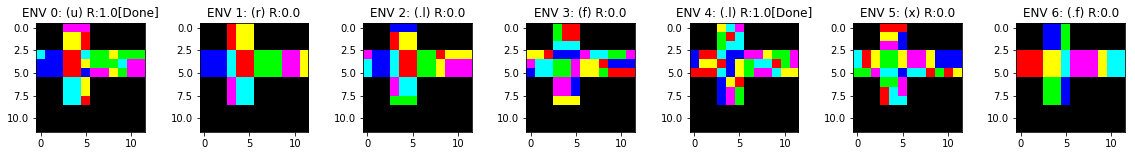

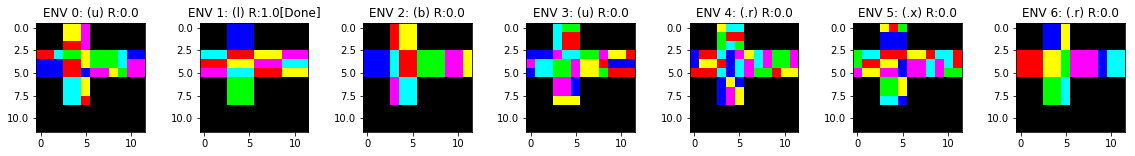

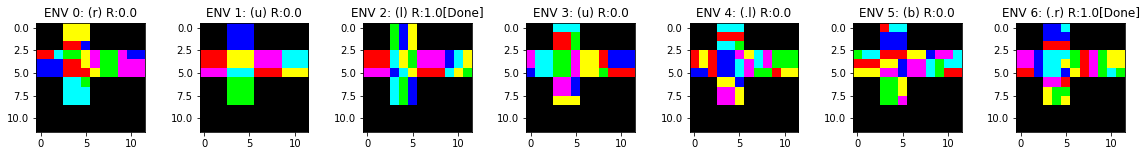

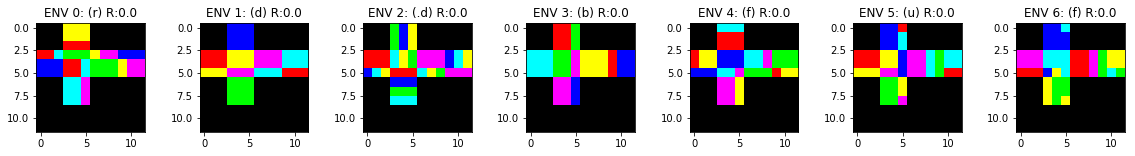

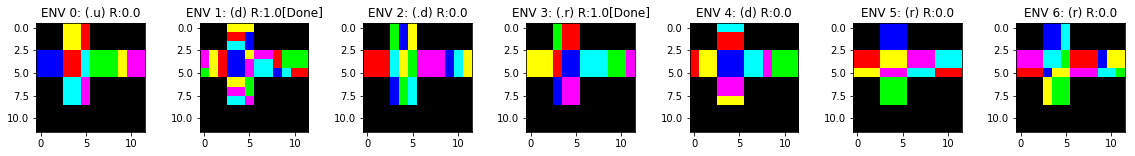

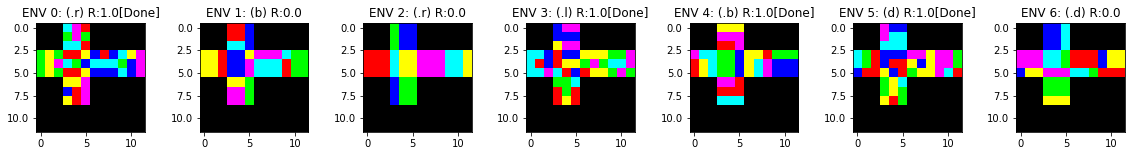

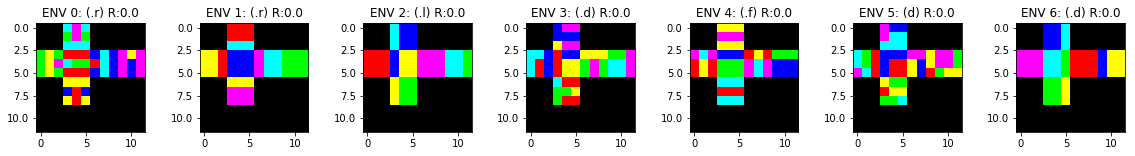

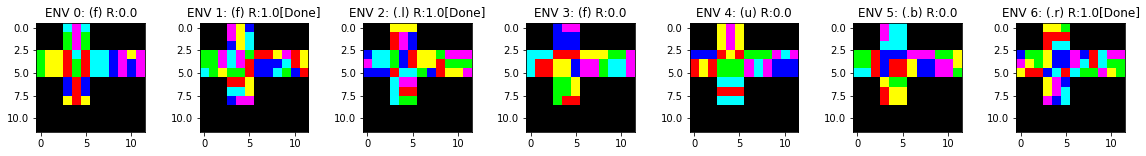

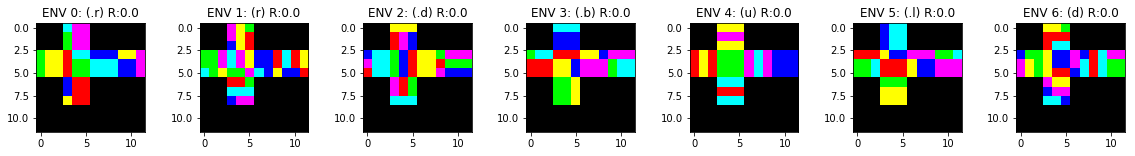

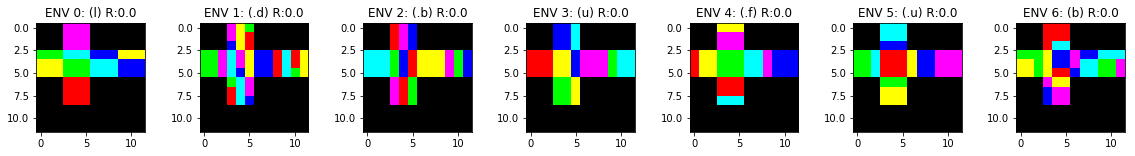

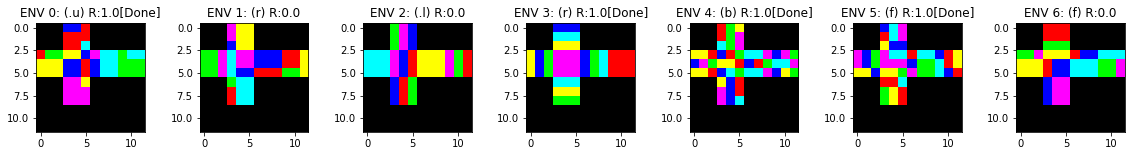

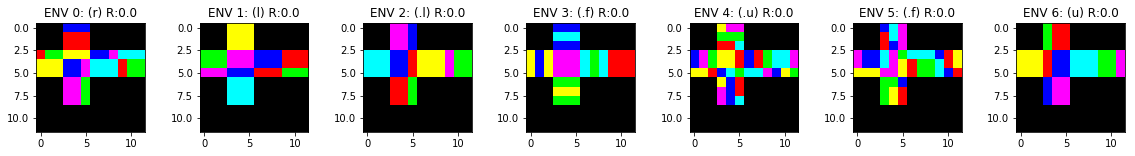

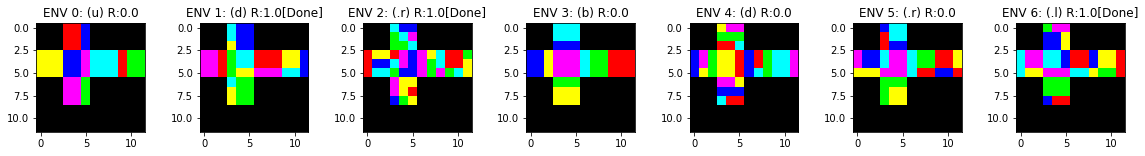

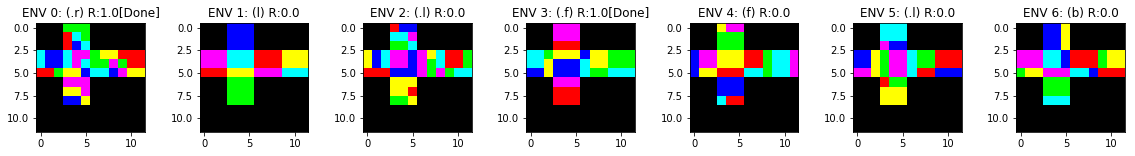

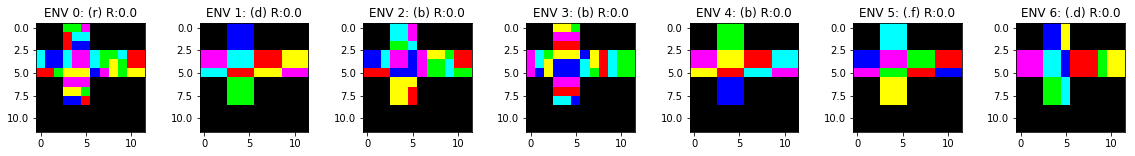

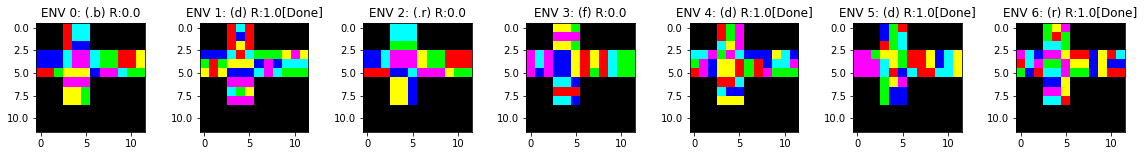

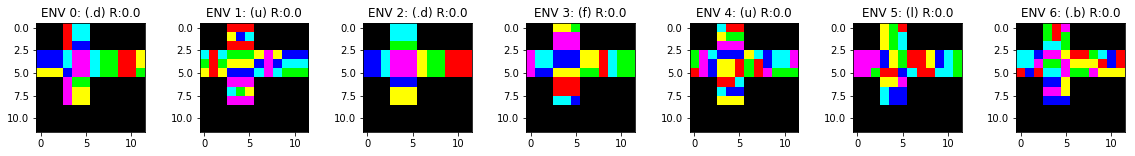

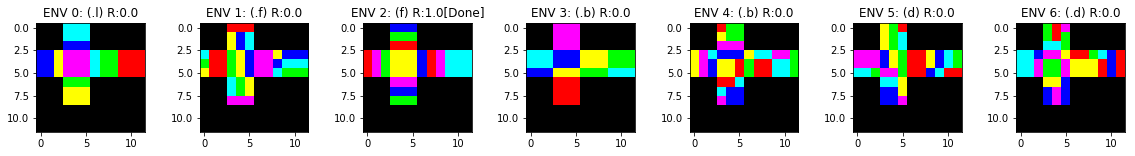

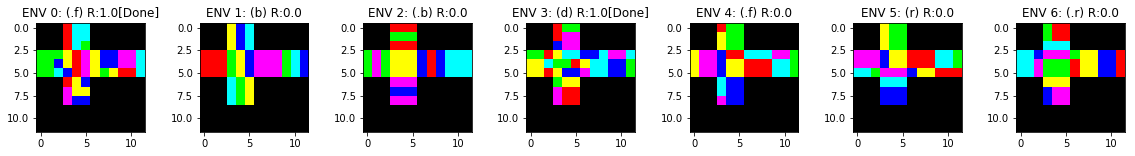

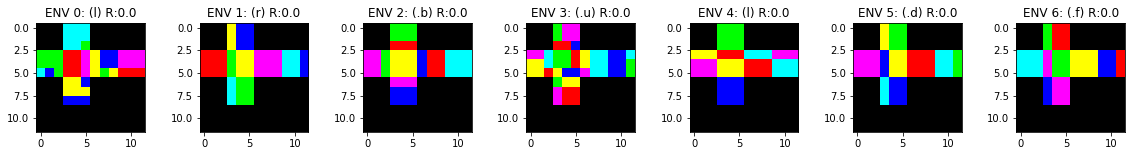

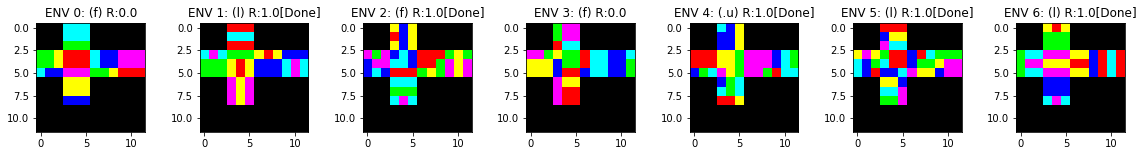

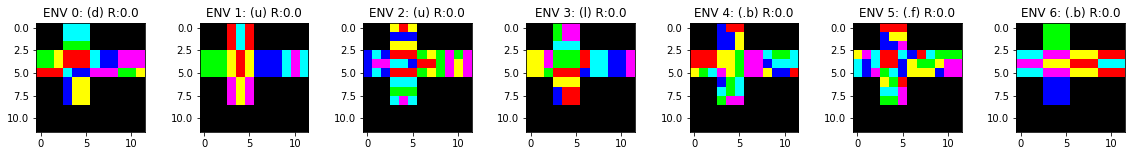

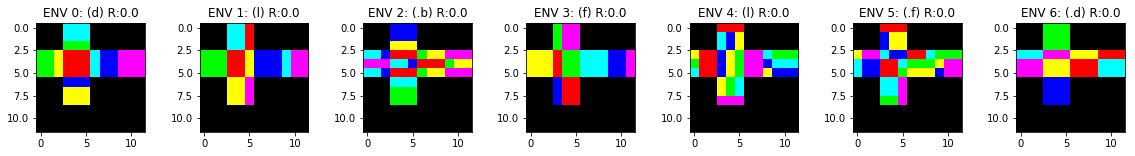

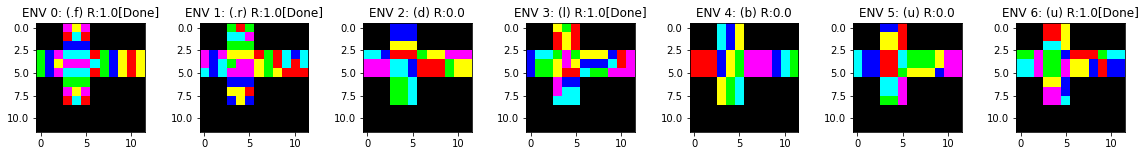

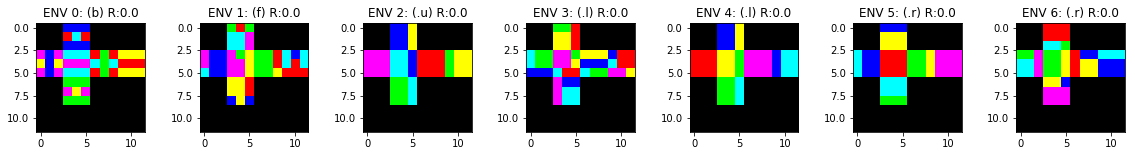

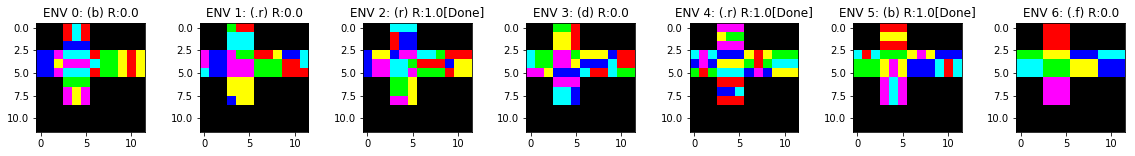

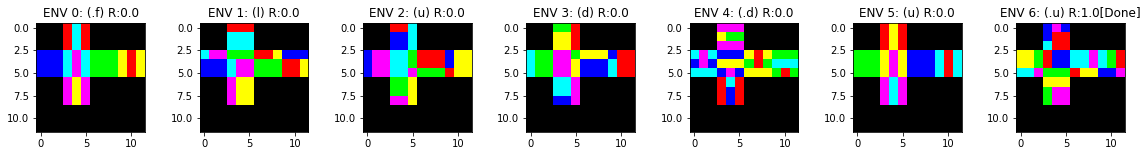

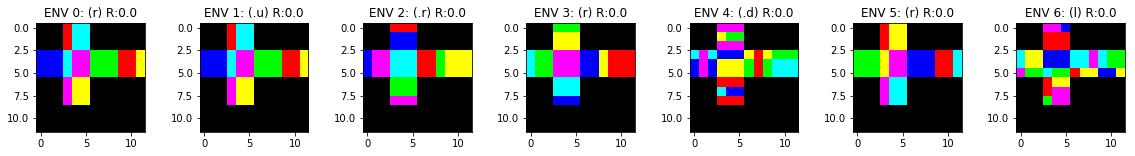

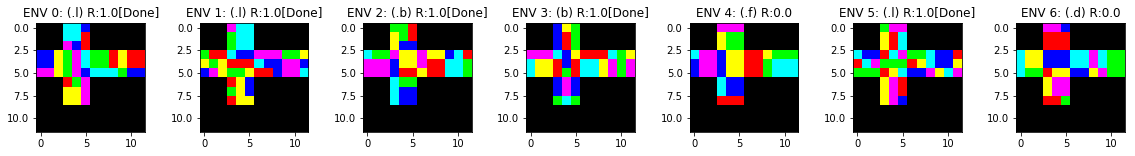

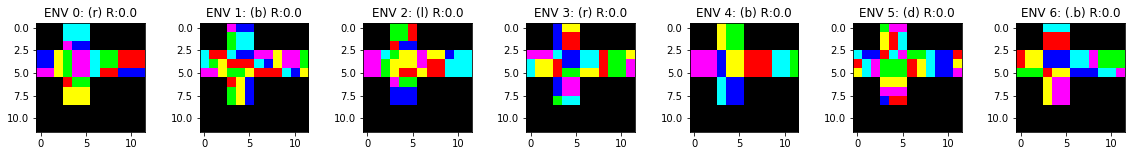

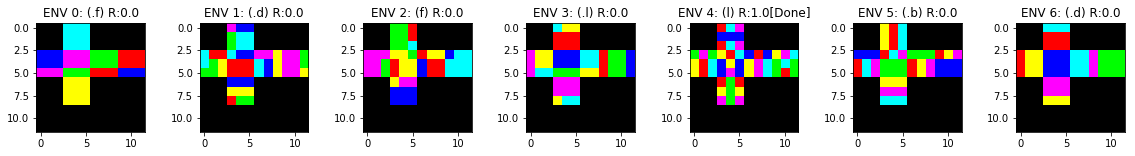

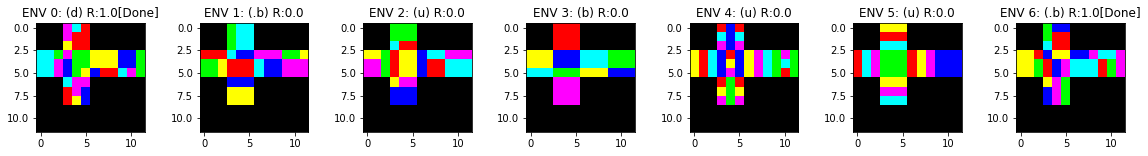

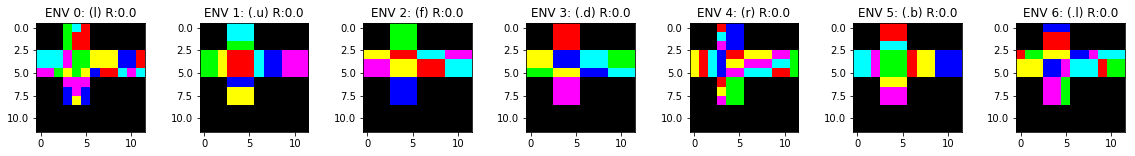

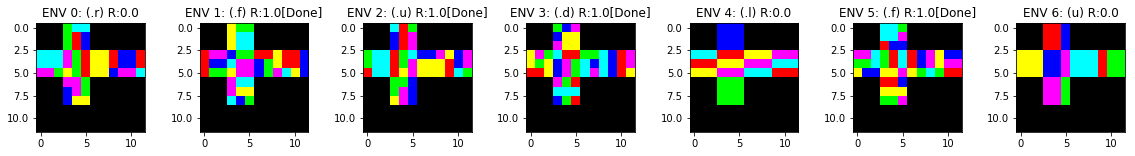

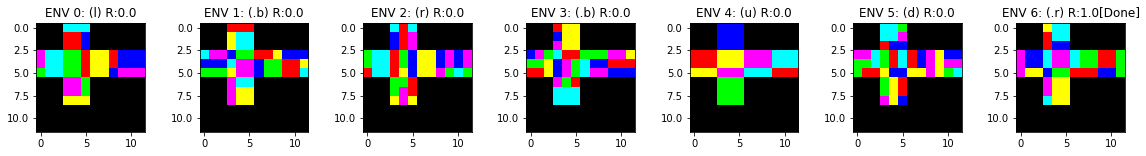

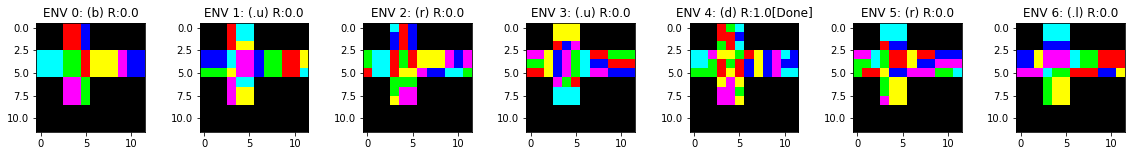

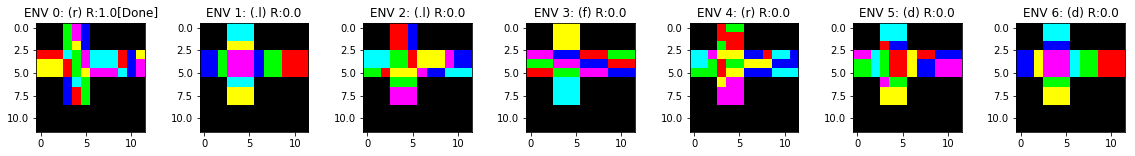

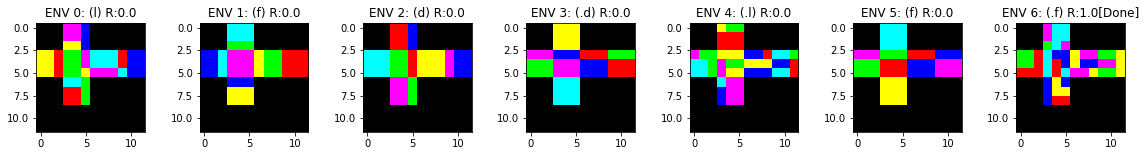

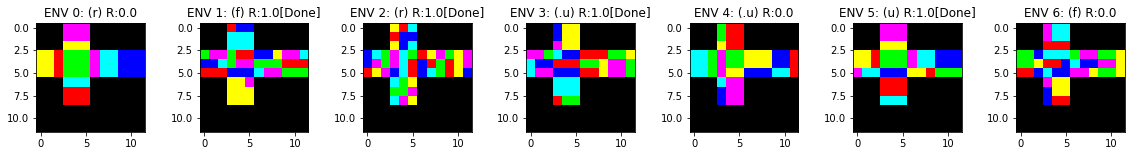

Solved:  100.0 / 101  --->  0.9900990099009901


In [7]:
# This will draw out the observations of multiple environments
def show_states(obs, name):
    plt.figure(figsize=(20, 2))
    for e in range(nenvs):
        plt.subplot(1, nenvs, e+1)
        plt.title('ENV ' + str(e) + ': ' + name[e])
        plt.imshow(cube_gym.onehotToRGB(obs[e]))
    plt.show()

# Show all the starting observations
obs = envs.reset()
if SHOW_STATES:
    show_states(obs, ['start' for _ in range(nenvs)])

def title(a, r ,d):
    if d:
        return '('+actions[a]+')'+' R:'+str(r)+'[Done]'
    else:
        return '('+actions[a]+')'+' R:'+str(r)
    
d = False
total = 0
solved = 0
while total < 100:

    a, _, _ = actor_critic.act(obs, stochastic=STOCHASTIC)
    obs, r, d, _ = envs.step(a)

    total += sum(d)
    solved += sum(r)
    
    if SHOW_STATES:
        show_states(obs, [title(x,y,z) for x,y,z in zip(a,r,d)])

print('Solved: ', solved, '/', total, ' ---> ', solved/total)